# Investigating OCIDRef

In [1]:
%load_ext autoreload
%autoreload 2

import json
import os

OCID_ref_root = '/scratch/gsk6me/WORLDMODELS/OCID-Ref'

with open(os.path.join(OCID_ref_root, "train_expressions.json")) as f:
    train_expressions = json.load(f)

with open(os.path.join(OCID_ref_root, "val_expressions.json")) as f:
    val_expressions = json.load(f)


In [2]:
keys = sorted(train_expressions.keys())

In [3]:
# Print a sample
i = 0
for key, expression in train_expressions.items():
    print("---")
    print("Key:", key)
    print(expression)
    i += 1
    if i == 10:
        break

---
Key: 83152
{'seq_id': 83, 'scene_id': 898, 'take_id': 18, 'scene_path': 'ARID20/floor/top/seq06/rgb/result_2018-08-20-11-37-31.png', 'sequence_path': 'ARID20/floor/top/seq06', 'sub_dataset': 'ARID20', 'instance_id': 5527, 'scene_instance_id': 18, 'class': 'food_box', 'class_instance': 'food_box_2', 'new_class': 'box', 'sentence': 'The food_box behind and on the bottom-left of the sponge.', 'tokens': ['The', 'food_box', 'behind', 'and', 'on', 'the', 'bottom-left', 'of', 'the', 'sponge'], 'bbox': '[172, 182, 259, 323]', 'sentence_id': '83152'}
---
Key: 10545
{'seq_id': 12, 'scene_id': 129, 'take_id': 9, 'scene_path': 'ARID10/floor/top/mixed/seq02/rgb/result_2018-08-24-17-08-45.png', 'sequence_path': 'ARID10/floor/top/mixed/seq02', 'sub_dataset': 'ARID10', 'instance_id': 705, 'scene_instance_id': 2, 'class': 'kleenex', 'class_instance': 'kleenex_3', 'new_class': 'box', 'sentence': 'The kleenex in front and on the bottom-right of the ball.', 'tokens': ['The', 'kleenex', 'in', 'front', 

### Thoughts

We need to replace underscores with spaces.

Almost every example is of the format (potentially descriptive object designation) \[(preposition) (other object)\]

Will there be enough data here, though?


In [4]:
len(train_expressions)

259839

It's possible there is enough data, but I am unsure whether the model will be able to suss out the minor details like colors and such.

# Investigating RefCOCOg

In [2]:
import refer

In [3]:
ds = refer.REFER(
    data_root='/scratch/gsk6me/WORLDMODELS/refcoco',
    image_root='/scratch/gsk6me/WORLDMODELS',
    dataset='refcocog',
    splitBy='umd'
)

loading dataset refcocog into memory...
creating index...
index created.
DONE (t=7.00s)


In [4]:
ref_ids = ds.getRefIds()

In [5]:
ds.getImgIds(ref_ids[:1])

[380440]

In [6]:
ds.loadRefs(ref_ids[:1])

[{'image_id': 380440,
  'split': 'test',
  'sentences': [{'tokens': ['the', 'man', 'in', 'yellow', 'coat'],
    'raw': 'the man in yellow coat',
    'sent_id': 8,
    'sent': 'the man in yellow coat'},
   {'tokens': ['skiier', 'in', 'red', 'pants'],
    'raw': 'Skiier in red pants.',
    'sent_id': 9,
    'sent': 'skiier in red pants'}],
  'file_name': 'COCO_train2014_000000380440_491042.jpg',
  'category_id': 1,
  'ann_id': 491042,
  'sent_ids': [8, 9],
  'ref_id': 0}]

[374.31, 65.06, 136.04, 201.94]


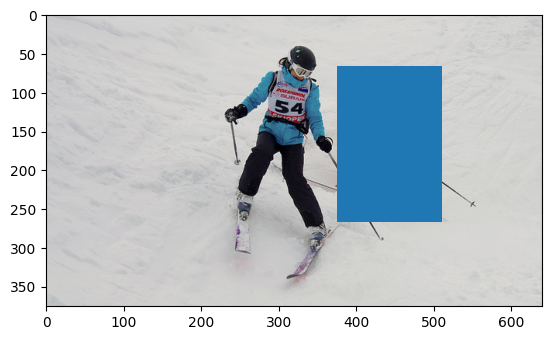

In [13]:
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ref = ds.loadRefs(ref_ids[:1])[0]
image = PIL.Image.open("/scratch/gsk6me/WORLDMODELS/train2014/COCO_train2014_000000380440.jpg")
annot = ds.Anns[ref['ann_id']]
bbox = annot['bbox']

print(bbox)

plt.imshow(image)
plt.gca().add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3]))

plt.show()


In [33]:
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np
import tqdm

# let's make a dataset.
rows_per_split = {'train': [], 'val': [], 'test': []}

image_sizes = {}

coco_split = 'train'


for ref_id, ref in tqdm.tqdm(ds.Refs.items(), desc='Generating rows', total=len(ds.Refs)):
    # Multiple refs can refer to the same object (which is an annotation)
    annot = ds.Anns[ref['ann_id']]
    
    coco_dir = f'/scratch/gsk6me/WORLDMODELS/{coco_split}2014'
    image_url = f"{coco_dir}/COCO_{coco_split}2014_{ref['image_id']:012d}.jpg"
    if image_url in image_sizes:
        width, height = image_sizes[image_url]
    else:
        image = PIL.Image.open(image_url).convert("RGB")
        width = image.width
        height = image.height
        image_sizes[image_url] = (width, height)

    # Get relative bounding box
    x1, y1, x2, y2 = annot['bbox']
    bbox_relative = np.array([x1 / width, y1 / height, x2 / width, y2 / height])
    bbox_relative *= 1024
    bbox_relative = bbox_relative.astype(int)
    x1, y1, x2, y2 = bbox_relative

    # Construct a prompt.
    prefix = f"Describe <loc{x1:04d}><loc{y1:04d}><loc{x2:04d}><loc{y2:04d}>"

    for sentence in ref['sentences']:
        suffix = "Answer: " + sentence['sent']

        rows_per_split[ref['split']].append({
            "image": image_url,
            "prefix": prefix,
            "suffix": suffix,
        })

# generate jsonl
for split in rows_per_split:
    with open(f"refcocog_{split}.jsonl", "w") as f:
        for row in rows_per_split[split]:
            json.dump(row, f)
            f.write('\n')


Generating rows: 100%|██████████| 49822/49822 [01:13<00:00, 673.65it/s] 


In [30]:
!ls /scratch/gsk6me/WORLDMODELS/val2014 | head -n 5

COCO_val2014_000000000042.jpg
COCO_val2014_000000000073.jpg
COCO_val2014_000000000074.jpg
COCO_val2014_000000000133.jpg
COCO_val2014_000000000136.jpg
ls: write error: Broken pipe


In [28]:
!head refcocog_train.jsonl

{"image": "/scratch/gsk6me/WORLDMODELS/train2014/COCO_train2014_000000380440.jpg", "prefix": "Describe <loc0598><loc0177><loc0217><loc0549>", "suffix": "Answer: the man in yellow coat"}
{"image": "/scratch/gsk6me/WORLDMODELS/train2014/COCO_train2014_000000380440.jpg", "prefix": "Describe <loc0598><loc0177><loc0217><loc0549>", "suffix": "Answer: skiier in red pants"}
{"image": "/scratch/gsk6me/WORLDMODELS/train2014/COCO_train2014_000000419645.jpg", "prefix": "Describe <loc0150><loc0197><loc0807><loc0690>", "suffix": "Answer: there is red colored truck in between the other trucks"}
{"image": "/scratch/gsk6me/WORLDMODELS/train2014/COCO_train2014_000000419645.jpg", "prefix": "Describe <loc0150><loc0197><loc0807><loc0690>", "suffix": "Answer: a shiny red vintage pickup truck"}
{"image": "/scratch/gsk6me/WORLDMODELS/train2014/COCO_train2014_000000478885.jpg", "prefix": "Describe <loc0542><loc0197><loc0235><loc0378>", "suffix": "Answer: a apple desktop computer"}
{"image": "/scratch/gsk6me/WO